### Import Required Packages

In [173]:
import pandas as pd
import numpy as np
from urllib2 import urlopen
from nltk.metrics import edit_distance, jaccard_distance
from sklearn.externals import joblib
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
import matplotlib.pyplot as plt
from wordcloud import WordCloud

## Creating Table E - Steps
1. Load blocked tuple pairs (1,217 pairs)
2. Load tables containing detailed information
    1. Spoj data (ltable)
    2. Codechef data (rtable)
3. Create table_D - blocked tuple pairs with detailed information
    1. exact_title_match
    2. diff_in_words_len (for the description)
    3. jaccard_sim (for the description)
    4. edit_dist (for the title)
4. Load and apply machine learning algorithm developed in project stage 4
    1. Logistic Regression Classifier
5. Create table_E with matching pairs from table_D
    1. 284 matches

In [2]:
# Step 1: Load blocked tuple pairs
blocked_set_url = "https://raw.githubusercontent.com/KaranTalreja/CS638/master/candidate_set.csv?token=AKuoLS_PLjUb7huP6wG6fd9O2YkUp_ICks5YWyaFwA%3D%3D"
blocked_set = pd.read_csv(urlopen(blocked_set_url)).set_index("_id")

In [3]:
# Step 2: Load Spoj & Codechef data (preprocessed in previous steps)
table_spoj = "spoj.csv"
ltable = pd.read_csv(table_spoj).drop("Unnamed: 0", axis=1)
ltable["words"] = ltable["description"].fillna("") + ltable["input"].fillna("") + ltable["output"].fillna("")
ltable = ltable.drop(["description", "input", "output"], axis=1).drop("difficulty_normalized", axis=1)

table_codechef = "codechef.csv"
rtable = pd.read_csv(table_codechef)
rtable["words"] = rtable["description"].fillna("") + rtable["input"].fillna("") + rtable["output"].fillna("")
rtable = rtable.drop(["description", "input", "output"], axis=1).drop("Unnamed: 0", axis=1)

In [4]:
# Step 3: Create table_D - blocked tuple pairs with detailed information
def exact_title_match(df):
    if ltable.ix[df["ltable_ID"]].title == rtable.ix[df["rtable_ID"]].title:
        return 1
    else:
        return 0
    
def words_length(df):
    l_word_len = len(ltable.ix[df["ltable_ID"]].words.split(" "))
    r_word_len = len(rtable.ix[df["rtable_ID"]].words.split(" "))
    return abs(l_word_len - r_word_len)

def jaccard_similarity(x,y):
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return intersection_cardinality/float(union_cardinality)

def jaccard_A_B(df):
    l_word_len = ltable.ix[df["ltable_ID"]].words.split(" ")
    r_word_len = rtable.ix[df["rtable_ID"]].words.split(" ")
    return jaccard_similarity(l_word_len, r_word_len)

def title_edit_dist(df):
    l_title = ltable.ix[df["ltable_ID"]].title
    r_title = rtable.ix[df["rtable_ID"]].title
    return edit_distance(l_title, r_title)
    
table_D = blocked_set
table_D["exact_title_match"] = blocked_set.apply(exact_title_match, axis=1)
table_D["diff_in_words_len"] = blocked_set.apply(words_length, axis=1)
table_D["jaccard_sim"] = blocked_set.apply(jaccard_A_B, axis=1)
table_D["edit_dist"] = blocked_set.apply(title_edit_dist, axis=1)
table_D.head()

,ltable_ID,rtable_ID,exact_title_match,diff_in_words_len,jaccard_sim,edit_dist
_id,,,,,,
2,0,5166,1,29,0.506329,0
1257,31,2205,0,65,0.802752,7
1470,64,5005,0,547,0.319549,7
1735,74,282,0,65,0.573964,6
1736,74,2885,0,44,0.716129,7


In [5]:
# Step 4: Load & Apply Logistic Regression Classifier trained in Stage 4
# Load Classifier
log_model = joblib.load('Stage 5/log_model.pkl')
log_pred = log_model.predict(table_D[["exact_title_match","diff_in_words_len","jaccard_sim","edit_dist"]])

# Apply Classifier
table_D["lr_pred_match"] = log_pred

# Select only matches
table_D_matches = table_D[table_D["lr_pred_match"] == 1][["ltable_ID","rtable_ID"]]
table_D_matches.head()

,ltable_ID,rtable_ID
_id,,
2,0,5166
1257,31,2205
1735,74,282
1736,74,2885
1856,102,3241


In [156]:
# Create table_E with matching pairs from table_D
def rtable_E_find(df):
    rt = rtable[rtable.index == df]
    data = pd.Series({
        "codechef_title": rt.title.values[0],
        "codechef_solve_rate_normalized": rt.solve_rate_normalized.values[0],
        "codechef_words": rt.words.values[0],
    })
    return data

def ltable_E_find(df):
    lt = ltable[ltable.index == df]
    data = pd.Series({
        "spoj_title": lt.title.values[0],
        "spoj_solve_rate_normalized": lt.solve_rate_normalized.values[0],
        "spoj_words": lt.words.values[0]
    })
    return data

def standardize(x):
    return (x - table_E.codechef_solve_rate_normalized.mean()) / table_E.codechef_solve_rate_normalized.std()

table_Er = table_D_matches.rtable_ID.apply(rtable_E_find)
table_El = table_D_matches.ltable_ID.apply(ltable_E_find)
table_E = table_El.merge(table_Er, left_index=True, right_index=True)
table_E = table_E.join(table_D).drop(2,axis=0)
table_E["codechef_solve_rate_normalized"] = table_E.codechef_solve_rate_normalized.apply(standardize)
table_E["spoj_solve_rate_normalized"] = table_E.spoj_solve_rate_normalized.apply(standardize)
table_E.head(3)

,spoj_solve_rate_normalized,spoj_title,spoj_words,codechef_solve_rate_normalized,codechef_title,codechef_words,ltable_ID,rtable_ID,exact_title_match,diff_in_words_len,jaccard_sim,edit_dist,lr_pred_match
_id,,,,,,,,,,,,,
1257,-0.306566,CAPPIZZA,"Brunno Doiuna is very fond of caper pizzas, ...",-0.208319,CDS008,"Brunno Doiuna is very fond of caper pizzas, wh...",31,2205,0,65,0.802752,7,1
1735,6.717850,FASHION,A fashion show rates participants according ...,-0.201181,CDSE03,A quiz show rates participants according to t...,74,282,0,65,0.573964,6,1
1736,6.717850,FASHION,A fashion show rates participants according ...,-0.200870,VITC04,Vibrance rates participants according to their...,74,2885,0,44,0.716129,7,1


In [157]:
table_E.to_csv("table_E.csv")

In [158]:
print table_E.codechef_solve_rate_normalized.describe()
print table_E.spoj_solve_rate_normalized.describe()

count    2.830000e+02
mean     1.475067e-16
std      1.000000e+00
min     -2.090350e-01
25%     -2.079420e-01
50%     -2.036574e-01
75%     -1.768757e-01
max      1.058103e+01
Name: codechef_solve_rate_normalized, dtype: float64
count    283.000000
mean       0.948334
std        2.684529
min       -0.327310
25%       -0.278066
50%       -0.165771
75%        0.481786
max       13.539173
Name: spoj_solve_rate_normalized, dtype: float64


                                spoj_solve_rate_normalized  \
spoj_solve_rate_normalized                        1.000000   
codechef_solve_rate_normalized                    0.163275   

                                codechef_solve_rate_normalized  
spoj_solve_rate_normalized                            0.163275  
codechef_solve_rate_normalized                        1.000000  


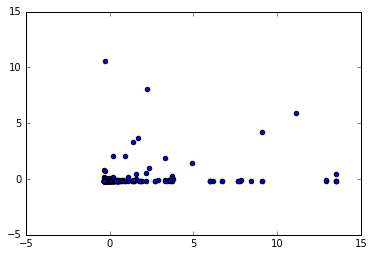

In [159]:
plt.scatter(table_E["spoj_solve_rate_normalized"], table_E["codechef_solve_rate_normalized"])
print table_E[["spoj_solve_rate_normalized", "codechef_solve_rate_normalized"]].corr()
plt.axis([-5, 15, -5, 15])
plt.show()

In [253]:
def remove_stopwords(sent):
    return list(set(word_tokenize(sent.lower())) - set((stopwords.words('english'))) - set(["input","output","=","<",".",":",",","0","1","2","3","n","(",")","4","5","6","-","7","8","9","10"]))
    
spoj_hard_words = []
for i in table_E[table_E["spoj_solve_rate_normalized"] >= 0.481786].spoj_words.apply(remove_stopwords):
    spoj_hard_words += i
spoj_hard_words_str = ""
for word in spoj_hard_words:
    spoj_hard_words_str += " " + word

codechef_hard_words = []
for i in table_E[table_E["codechef_solve_rate_normalized"] >= -0.1768757].codechef_words.apply(remove_stopwords):
    codechef_hard_words += i 
codechef_hard_words_str = ""  
for word in codechef_hard_words:
    codechef_hard_words_str += " " + word

In [254]:
spoj_freq = pd.DataFrame(FreqDist(word_tokenize(spoj_hard_words_str)).most_common(10), columns=["word","count"])
codechef_freq = pd.DataFrame(FreqDist(word_tokenize(codechef_hard_words_str.decode('utf-8'))).most_common(10), columns=["word","count"])

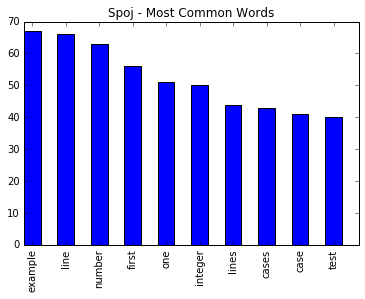

In [255]:
x = spoj_freq["count"]
ind = np.arange(len(x))
width = 0.5
plt.bar(ind,x, width=width)
plt.xticks(ind + width / 2, spoj_freq["word"], rotation='vertical')
plt.title("Spoj - Most Common Words")
plt.savefig("spoj_most_common_words.png")
plt.show()

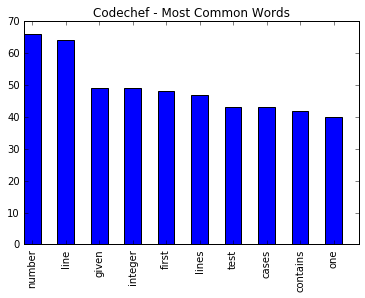

In [256]:
x = codechef_freq["count"]
ind = np.arange(len(x))
width = 0.5
plt.bar(ind,x, width=width)
plt.xticks(ind + width / 2, codechef_freq["word"], rotation='vertical')
plt.title("Codechef - Most Common Words")
plt.savefig("codechef_most_common_words.png")
plt.show()

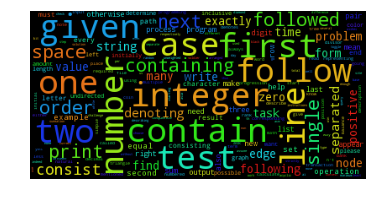

In [257]:
wordcloud = WordCloud().generate(spoj_hard_words_str)

# Display the generated image:
# the matplotlib way:
# plt.imshow(wordcloud)
# plt.axis("off")

# # lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(codechef_hard_words_str)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('spoj_hard_words.png')
plt.show()

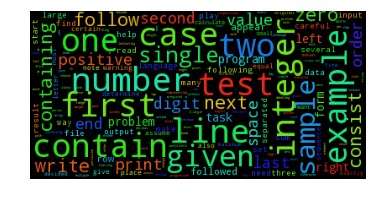

In [258]:
# # lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(spoj_hard_words_str)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('codechef_hard_words.png')
plt.show()